Arquivo original: DimEstWav.m

In [2]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import pywt
from scipy.stats import norm
import matplotlib.pyplot as plt

In [22]:
# DimEstWav/DimEst_boot.m
def DimEst_boot(Y, NREP, B, p, N, wname):
    """
    Python translation of MATLAB DimEst_boot.

    Parameters
    ----------
    Y : array (nt x n)
        Functional observations
    NREP : int
        Number of bootstrap replications
    B : array (J x d0)
        Eigenvector matrix (wavelet coefficients of estimated eigenfunctions)
    p : int
        Maximum lag
    N : int
        Wavelet decomposition level
    wname : str
        Wavelet name (e.g. 'db2')

    Returns
    -------
    vd0p1_boot : array (NREP,)
        Bootstrap estimates of eigenvalue_{d0+1}
    """

    J, d0 = B.shape
    nt, n = Y.shape

    vd0p1_boot = np.zeros(NREP)
    Yhat = np.zeros((nt, n))
    H = np.zeros((nt, d0))
    A = np.zeros((J, n))
    Yboot = np.zeros((nt, n))
    Aboot = np.zeros((J, n))

    # =====================================================================
    # Compute wavelet decomposition of Y
    # =====================================================================
    # Get coefficient slicing lengths using first column
    coeffs0 = pywt.wavedec(Y[:, 0], wname, level=N)
    lengths = [len(c) for c in coeffs0]

    for ii in range(n):
        coeffs = pywt.wavedec(Y[:, ii], wname, level=N)
        A[:, ii] = np.concatenate(coeffs)

    mu_A = A.mean(axis=1, keepdims=True)
    C = A - mu_A

    # =====================================================================
    # Reconstruct mean function using inverse wavelet transform
    # =====================================================================
    def waverec_from_vector(v):
        out = []
        idx = 0
        for L in lengths:
            out.append(v[idx:idx+L])
            idx += L
        return pywt.waverec(out, wname)

    mu_hat = waverec_from_vector(mu_A[:, 0])

    # =====================================================================
    # Reconstruct eigenfunctions H(:,k)
    # =====================================================================
    for ii in range(d0):
        H[:, ii] = waverec_from_vector(B[:, ii])

    # =====================================================================
    # Compute fitted curves Yhat
    # =====================================================================
    for ii in range(n):
        Yhat[:, ii] = mu_hat.copy()
        for k in range(d0):
            coef = C[:, ii].T @ B[:, k]   # inner product
            Yhat[:, ii] += coef * H[:, k]

    mEps_hat = Y - Yhat

    # =====================================================================
    # Bootstrap replications
    # =====================================================================
    for jj in range(NREP):

        # Resample residual curves with replacement
        for ii in range(n):
            idx = np.random.randint(0, n)
            Yboot[:, ii] = Yhat[:, ii] + mEps_hat[:, idx]

            coeffs = pywt.wavedec(Yboot[:, ii], wname, level=N)
            Aboot[:, ii] = np.concatenate(coeffs)

        mu_Aboot = Aboot.mean(axis=1, keepdims=True)
        Cb = Aboot - mu_Aboot

        C1 = Cb[:, :n-p]
        D1 = np.zeros((n-p, n-p))

        for k in range(1, p+1):
            Ct = Cb[:, k:(n-p+k)]
            D1 += Ct.T @ Ct

        Dboot = C1 @ D1 @ C1.T / ((n - p)**2)

        # eigen-decomposition
        Lboot, Bboot = np.linalg.eig(Dboot)

        # MATLAB takes Lboot(d0+1,d0+1), but eigenvalues are unordered.
        # We sort them descending to match MATLAB's behavior.
        L_sorted = np.sort(Lboot)[::-1]

        vd0p1_boot[jj] = L_sorted[d0]

    return vd0p1_boot

In [23]:

# ==========================================================
# PARAMETERS
# ==========================================================
n = 100          # sample size
d = 2            # dimension parameter
nt = 256         # number of grid points
u = np.linspace(0.01, 0.99, nt)[:, None]  # nt x 1 grid
N = 3            # wavelet decomposition level

# ==========================================================
# ARIMA PROCESSES FOR UNOBSERVED FUNCTIONAL DYNAMICS
# ==========================================================


def simulate_ar1(phi, n, sigma2=1.5):
    x = np.zeros(n)
    eps = np.random.normal(scale=np.sqrt(sigma2), size=n)
    for t in range(1, n):
        x[t] = phi * x[t-1] + eps[t]
    return x

# simulate processes
xi1 = simulate_ar1(-0.65, n)
xi2 = simulate_ar1( 0.40, n)

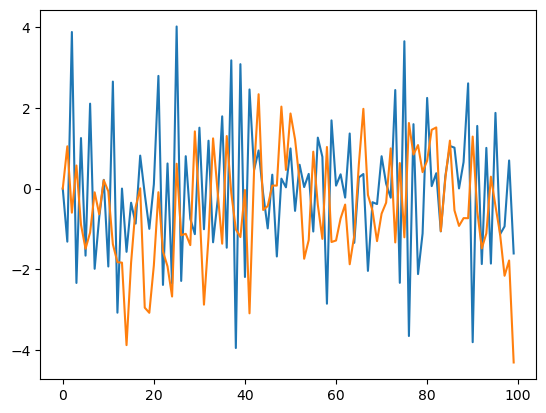

In [24]:
plt.figure()

plt.plot(xi1)
plt.plot(xi2)

plt.show()

In [25]:

# ==========================================================
# GENERATE UNOBSERVED FUNCTIONAL DATA X(t)
# ==========================================================
X = np.zeros((nt, n))

for ii in range(n):
    X[:, ii] = (
        xi1[ii] * np.sqrt(2) * np.cos(np.pi * u[:, 0]) +
        xi2[ii] * np.sqrt(2) * np.cos(2 * np.pi * u[:, 0])
    )

In [26]:

# ==========================================================
# ADD NOISE USING SINE SERIES
# ==========================================================
mEps = np.zeros((nt, n))

for ii in range(n):
    for jj in range(1, 11):
        mEps[:, ii] += (
            norm.rvs(scale=1.0) * np.sqrt(2) *
            np.sin(np.pi * u[:, 0] * jj) / (2 ** (jj - 1))
        )

In [27]:

# ==========================================================
# OBSERVED FUNCTIONAL DATA
# ==========================================================
Y = X + mEps

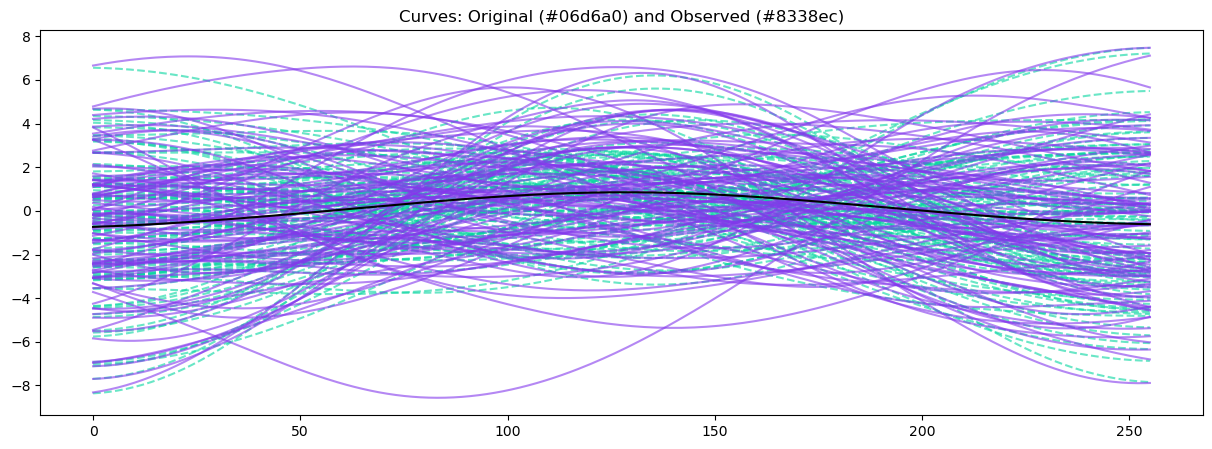

In [28]:
plt.figure(figsize=(15,5))


color_original = "#06d6a0"
plt.plot(X, alpha=.6, c=color_original, linestyle="--",label="Unobserved")

color_observed = "#8338ec"
plt.plot(Y, alpha=.6, c=color_observed, label="Observed")

plt.plot(np.mean(Y,axis=1), c="black")

plt.title(f"Curves: Original ({color_original}) and Observed ({color_observed})")

plt.show()

In [29]:

# ==========================================================
# WAVELET DECOMPOSITION
# ==========================================================
wavelet = "db2"
J = 263  # MATLAB-specific number of coefficients
A = np.zeros((J, n))

dec_example = pywt.wavedec(Y[:, 0], wavelet, level=N)
# compute slicing index to reconstruct full coefficient vector
lengths = [len(c) for c in dec_example]
cum_len = np.sum(lengths)

for ii in range(n):
    coeffs = pywt.wavedec(Y[:, ii], wavelet, level=N)
    A[:, ii] = np.concatenate(coeffs)

mu_A = A.mean(axis=1, keepdims=True)
C = A - mu_A

In [30]:

# ==========================================================
# BUILD MATRIX D
# ==========================================================
p = 5
C1 = C[:, :n-p]
D1 = np.zeros((n-p, n-p))

for k in range(1, p+1):
    Ct = C[:, k:(n-p+k)]
    D1 += Ct.T @ Ct

D = C1 @ D1 @ C1.T / ((n - p)**2)

In [31]:

# ==========================================================
# EIGEN-DECOMPOSITION
# ==========================================================
L, B = np.linalg.eig(D)

# sort eigenvalues descending
idx = np.argsort(-L)
L = L[idx]
B = B[:, idx]

print(L[:10])

print(np.linalg.norm(L[:4], 1) / np.linalg.norm(L, 1))

[6.01168039e+05+0.j 8.04052445e+04+0.j 1.84246975e+04+0.j
 4.94317545e+02+0.j 3.14987024e+02+0.j 1.20106737e+02+0.j
 4.33827029e+01+0.j 1.16355124e+01+0.j 1.82403347e+00+0.j
 4.02822682e-01+0.j]
0.9992974916283116


In [32]:

# ==========================================================
# WAVELET RECONSTRUCTION OF MEAN FUNCTION
# ==========================================================
# reconstruct mean using stored lengths
def reconstruct(coeff_vector, lengths):
    coeffs = []
    offset = 0
    for Lg in lengths:
        coeffs.append(coeff_vector[offset:offset+Lg])
        offset += Lg
    return pywt.waverec(coeffs, wavelet)

mu_hat = reconstruct(mu_A[:, 0], lengths)


# mu_hat =  pywt.waverec(mu_A,Lw,'db2')

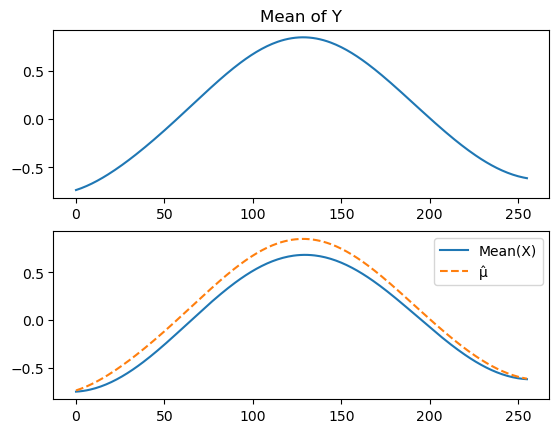

In [33]:
plt.subplot(2,1,1)
plt.plot(Y.mean(axis=1))
plt.title("Mean of Y")

plt.subplot(2,1,2)
plt.plot(X.mean(axis=1), label="Mean(X)")
plt.plot(mu_hat, label="μ̂", linestyle='--')
plt.legend()
plt.show()

In [34]:
NREP = 100
alpha = 0.1
d0 = 2
wname = 'db2'

d_boot = DimEst_boot(Y, NREP, B[:, :d0], p, N, wname)

print("Bootstrap p-value:", np.mean(d_boot > L[d0]))
print("Reject?", np.mean(d_boot > L[d0]) <= alpha)

C:\Users\user\AppData\Local\Temp\ipykernel_18212\4217732593.py:68: ComplexWarning: Casting complex values to real discards the imaginary part
  H[:, ii] = waverec_from_vector(B[:, ii])


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

# V2

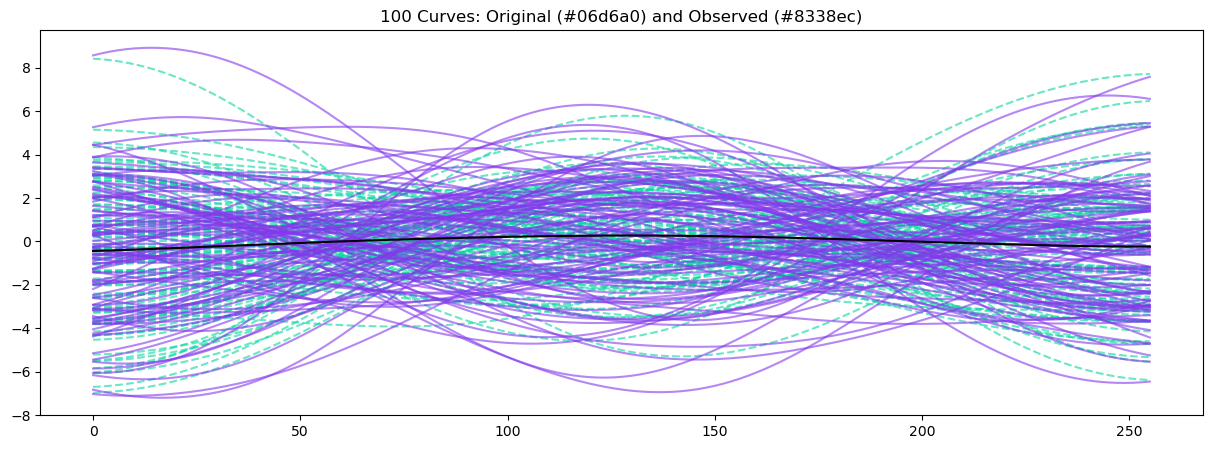

In [66]:
# Simulação


# ==========================================================
# PARAMETERS
# ==========================================================
n = 100          # sample size (curves)
d = 2            # dimension parameter
nt = 256         # number of grid points
u = np.linspace(0.01, 0.99, nt)[:, None]  # nt x 1 grid
N = 3            # wavelet decomposition level

# ==========================================================
# ARIMA PROCESSES FOR UNOBSERVED FUNCTIONAL DYNAMICS
# ==========================================================


def simulate_ar1(phi, n, sigma2=1.5):
    x = np.zeros(n)
    eps = np.random.normal(scale=np.sqrt(sigma2), size=n)
    for t in range(1, n):
        x[t] = phi * x[t-1] + eps[t]
    return x

# simulate processes
xi1 = simulate_ar1(-0.65, n)
xi2 = simulate_ar1( 0.40, n)

# ==========================================================
# GENERATE UNOBSERVED FUNCTIONAL DATA X(t)
# ==========================================================
X = np.zeros((nt, n))

for ii in range(n):
    X[:, ii] = (
        xi1[ii] * np.sqrt(2) * np.cos(np.pi * u[:, 0]) +
        xi2[ii] * np.sqrt(2) * np.cos(2 * np.pi * u[:, 0])
    )


# ==========================================================
# ADD NOISE USING SINE SERIES
# ==========================================================
mEps = np.zeros((nt, n))

for ii in range(n):
    for jj in range(1, 11):
        mEps[:, ii] += (
            norm.rvs(scale=1.0) * np.sqrt(2) *
            np.sin(np.pi * u[:, 0] * jj) / (2 ** (jj - 1))
        )


# ==========================================================
# OBSERVED FUNCTIONAL DATA
# ==========================================================
Y = X + mEps


plt.figure(figsize=(15,5))


color_original = "#06d6a0"
plt.plot(X, alpha=.6, c=color_original, linestyle="--",label="Unobserved")

color_observed = "#8338ec"
plt.plot(Y, alpha=.6, c=color_observed, label="Observed")

plt.plot(np.mean(Y,axis=1), c="black")

plt.title(f"{n} Curves: Original ({color_original}) and Observed ({color_observed})")

plt.show()

In [69]:
Y.shape

(256, 100)

In [94]:
def wavedec_sizes(signal_length, wavelet_name, level):
    """
    Compute expected pywt.wavedec sizes:
      returns sizes = [len(A_N), len(D_N), ..., len(D_1)]
      and total = sum(sizes)
    """
    w = pywt.Wavelet(wavelet_name)
    F = w.dec_len
    L = signal_length

    lengths = []
    Lj = L
    for j in range(level):
        Lj = (Lj + F - 1) // 2
        lengths.append(Lj)

    # lengths = [L1, L2, ..., L_N] where lengths[-1] == A_N length
    # we want [A_N, D_N, D_{N-1}, ..., D_1]
    sizes = [lengths[-1]] + lengths[::-1]

    total = sum(sizes)
    return sizes, total

In [97]:
# % número de coefientes da base de ondaletas usada
# J = 263;
# % matriz de cujas colunas terão a decomposição em ondaletas
# % de cada funcional observado (coluna da matriz Y)
# A = zeros(J,n);y

wvlt = 'db2'
sizes, total = wavedec_sizes(nt, wvlt, N)
# J = 263
J = total
A = np.zeros([J,n]) # grid_points X curves

In [108]:
# % decomposição de cada funcional dos n dias
# for ii = 1:n
#     % D aqui irá receber os coeficiente de aproximação e L
#     % os coeficientes de detalhes
#     %[D,L] = dwt(Y(:,ii),'db2');
#     % os coeficientes são empilhados na i-ésima coluna de A
#     %A(:,ii) = [D',L']';
#     [A(:,ii),Lw] = wavedec(Y(:,ii),N,'db2');
        # OBSERVAÇÃO: Lw=[len(AN​),len(DN​),len(DN−1​),…,len(D1​)]
#     %[thr,sorh,keepapp] = ddencmp('den','wv',Y(:,ii));
#     %[~,Aths(:,ii),Lwths,~,~] = wdencmp('gbl',A(:,ii),Lw,'db1',1,thr,sorh,keepapp);
#     %[~,Aths(:,ii),Lwths] = wden(Y(:,ii),'sqtwolog','h','mln',N,'db2');
# end

for ii in range(1,n):
    dwt_coefficients = pywt.wavedec(
        data = Y[:,0],
        wavelet = 'db2',
        level=N)
    stacked_dwt_coeffs = np.concatenate(dwt_coefficients)
    A[:, ii] = stacked_dwt_coeffs

In [115]:
# %A = Aths;
# % esse vetor terá a média de um determinado coeficiente
# % ao longo dos n dias
# mu_A = mean(A,2);

# % matriz com os desvios dos coeficientes em relação à
# % média dos coeficientes num mesmo dia
# C = A - mu_A*ones(1,n);

mu_A = np.mean(A, axis=1, keepdims=True)

C = A - mu_A

In [118]:
C.shape

(263, 100)

In [116]:
# % agora será obtida a matriz formada pelos coeficientes das
# % decomposições das observações dos funcionais. Aqui, tomamos
# % p=5.
# p = 5;

# C1 = C(:,[1:(n-p)]);
# D1 = zeros(n-p,n-p);
# for k=1:p
#     D1 = D1 + C(:,[(k+1):(n-p+k)])'*C(:,[(k+1):(n-p+k)]);
# end
# D = C1*D1*C1'/((n-p)^2);

p=5

C1 = C[:, :n-p]
D1 = np.zeros((n-p, n-p))

for k in range(1, p+1):
    Ct = C[:, k:(n-p+k)]
    D1 += Ct.T @ Ct

D = C1 @ D1 @ C1.T / ((n - p)**2)

In [142]:
# % após obter D, calculamos os autovetores e autovalores da mesma.
# % as colunas de B terão os autovetores de D, que são os coeficientes de
# % ondaletas das autofunções associadas aos autovalores na diagonal de L
# [B,L] = eig(D);
# plot(diag(L(1:10,1:10)))

L, B = np.linalg.eig(D)

# sort eigenvalues descending
idx = np.argsort(-L)
L = L[idx]
B = B[:, idx]

c:\Users\user\anaconda3\envs\densities4risk\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\user\anaconda3\envs\densities4risk\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


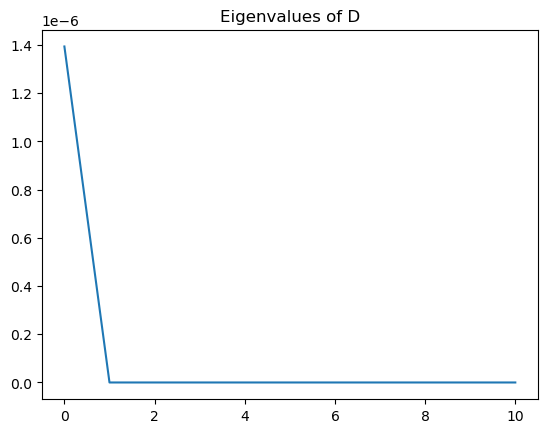

In [150]:
plt.figure()

plt.plot(L[:11])

plt.title("Eigenvalues of D")

plt.show()

In [151]:
# proportion of the total eigenvalue mass contained in the first 4 eigenvalues
print(np.linalg.norm(L[:4], 1) / np.linalg.norm(L, 1))

0.9999999999999686


In [152]:
# % tomando a transformada inversa da função média
# mu_hat =  waverec(mu_A,Lw,'db2');

def reconstruct(coeff_vector, lengths):
    coeffs = []
    offset = 0
    for Lg in lengths:
        coeffs.append(coeff_vector[offset:offset+Lg])
        offset += Lg
    return pywt.waverec(coeffs, wavelet)

mu_hat = reconstruct(mu_A[:, 0], lengths)

ValueError: coefficient shape mismatch